In [ ]:
# %pip install augraphy albumentations tqdm


In [1]:
import os
import cv2
import pandas as pd
from tqdm import tqdm
from augraphy import *
from albumentations import (
    Rotate, 
    GaussNoise, 
    RandomBrightnessContrast, 
    RandomResizedCrop,
    Compose
)

# 데이터 경로 설정
input_dir = "data/train"
output_dir = "data/augmented_v3_x50_cleaning"
csv_input_path = "data/train.csv"
csv_output_path = "data/augment_v3_x50_cleaning.csv"

# 출력 디렉토리 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Augraphy 증강 파이프라인 설정 (잉크 낙서 효과 제외)
pipeline_aug = AugraphyPipeline([
    LightingGradient(p=0.5),   # 조명 그라디언트를 추가하여 문서나 페이지의 일부가 더 밝거나 어둡게 보임 
    SubtleNoise(p=0.5),   # 페이지에 미세한 노이즈를 추가하여 약간의 텍스처를 더함 
    BrightnessTexturize(p=0.5),   # 텍스처를 추가하면서 밝기를 조절
    PageBorder(p=0.5),   # 페이지에 테두리를 추가
])

# Albumentations 증강 파이프라인 설정
albumentations_aug = Compose([
    Rotate(limit=360, p=0.7),  # 회전: 'limit=45' 회전 각도의 최대치, 'p=0.5' 이 변환이 50% 확률로 적용됨 
    GaussNoise(var_limit=(1.0, 10.0), p=0.5),  # 노이즈 추가 (강도 줄임)
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # 밝기 및 대조 조절
    RandomResizedCrop(height=256, width=256, scale=(0.95, 1), ratio=(0.95, 1.05), p=0.7)  # 랜덤 크기로 조정 및 자르기
])

# CSV 파일 로드
df = pd.read_csv(csv_input_path)

# 오류 수정 사전
error_dic = [
    ('0583254a73b48ece.jpg', 12),
    ('1ec14a14bbe633db.jpg', 7),
    ('38d1796b6ad99ddd.jpg', 12),
    ('45f0d2dfc7e47c03.jpg', 7),
    ('7100c5c67aecadc5.jpg', 7),
    ('8646f2c3280a4f49.jpg', 3),
    ('aec62dced7af97cd.jpg', 14),
    ('c5182ab809478f12.jpg', 14)
]

# 오류 수정 적용
for id, target in error_dic:
    df.loc[df['ID'] == id, 'target'] = target

# CSV 파일에 저장할 데이터 리스트 초기화
csv_data = []

# 이미지 증강 및 저장
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    filename = row['ID']  # 'ID' 컬럼에서 파일명 추출
    target = row['target']  # 'target' 컬럼에서 클래스 추출
    
    # 이미지 경로 설정
    image_path = os.path.join(input_dir, filename)
    if not os.path.exists(image_path):
        continue
    
    # 이미지 로드
    image = cv2.imread(image_path)

    # 각 이미지에 대해 10개의 증강 이미지 생성
    for i in range(10):
        # Albumentations 증강 적용
        albumentations_image = albumentations_aug(image=image)['image']

        # Augraphy 증강 적용
        augraphy_image = pipeline_aug(albumentations_image)

        # 증강된 이미지 저장
        combined_output_path = os.path.join(output_dir, f"combined_{i}_{filename}")

        cv2.imwrite(combined_output_path, augraphy_image)

        # CSV 데이터 추가
        csv_data.append([f"combined_{i}_{filename}", target])

# 증강된 이미지 정보가 담긴 데이터프레임 생성 및 CSV 파일로 저장
augmented_df = pd.DataFrame(csv_data, columns=['ID', 'target'])
augmented_df.to_csv(csv_output_path, index=False)

100%|██████████| 1570/1570 [09:14<00:00,  2.83it/s]


In [ ]:
# # CSV 파일로 저장
# df = pd.DataFrame(csv_data, columns=["ID", "target"])
# df.to_csv(os.path.join(csv_output_path), index=False)

# print("이미지 증강 및 CSV 저장이 완료되었습니다.")

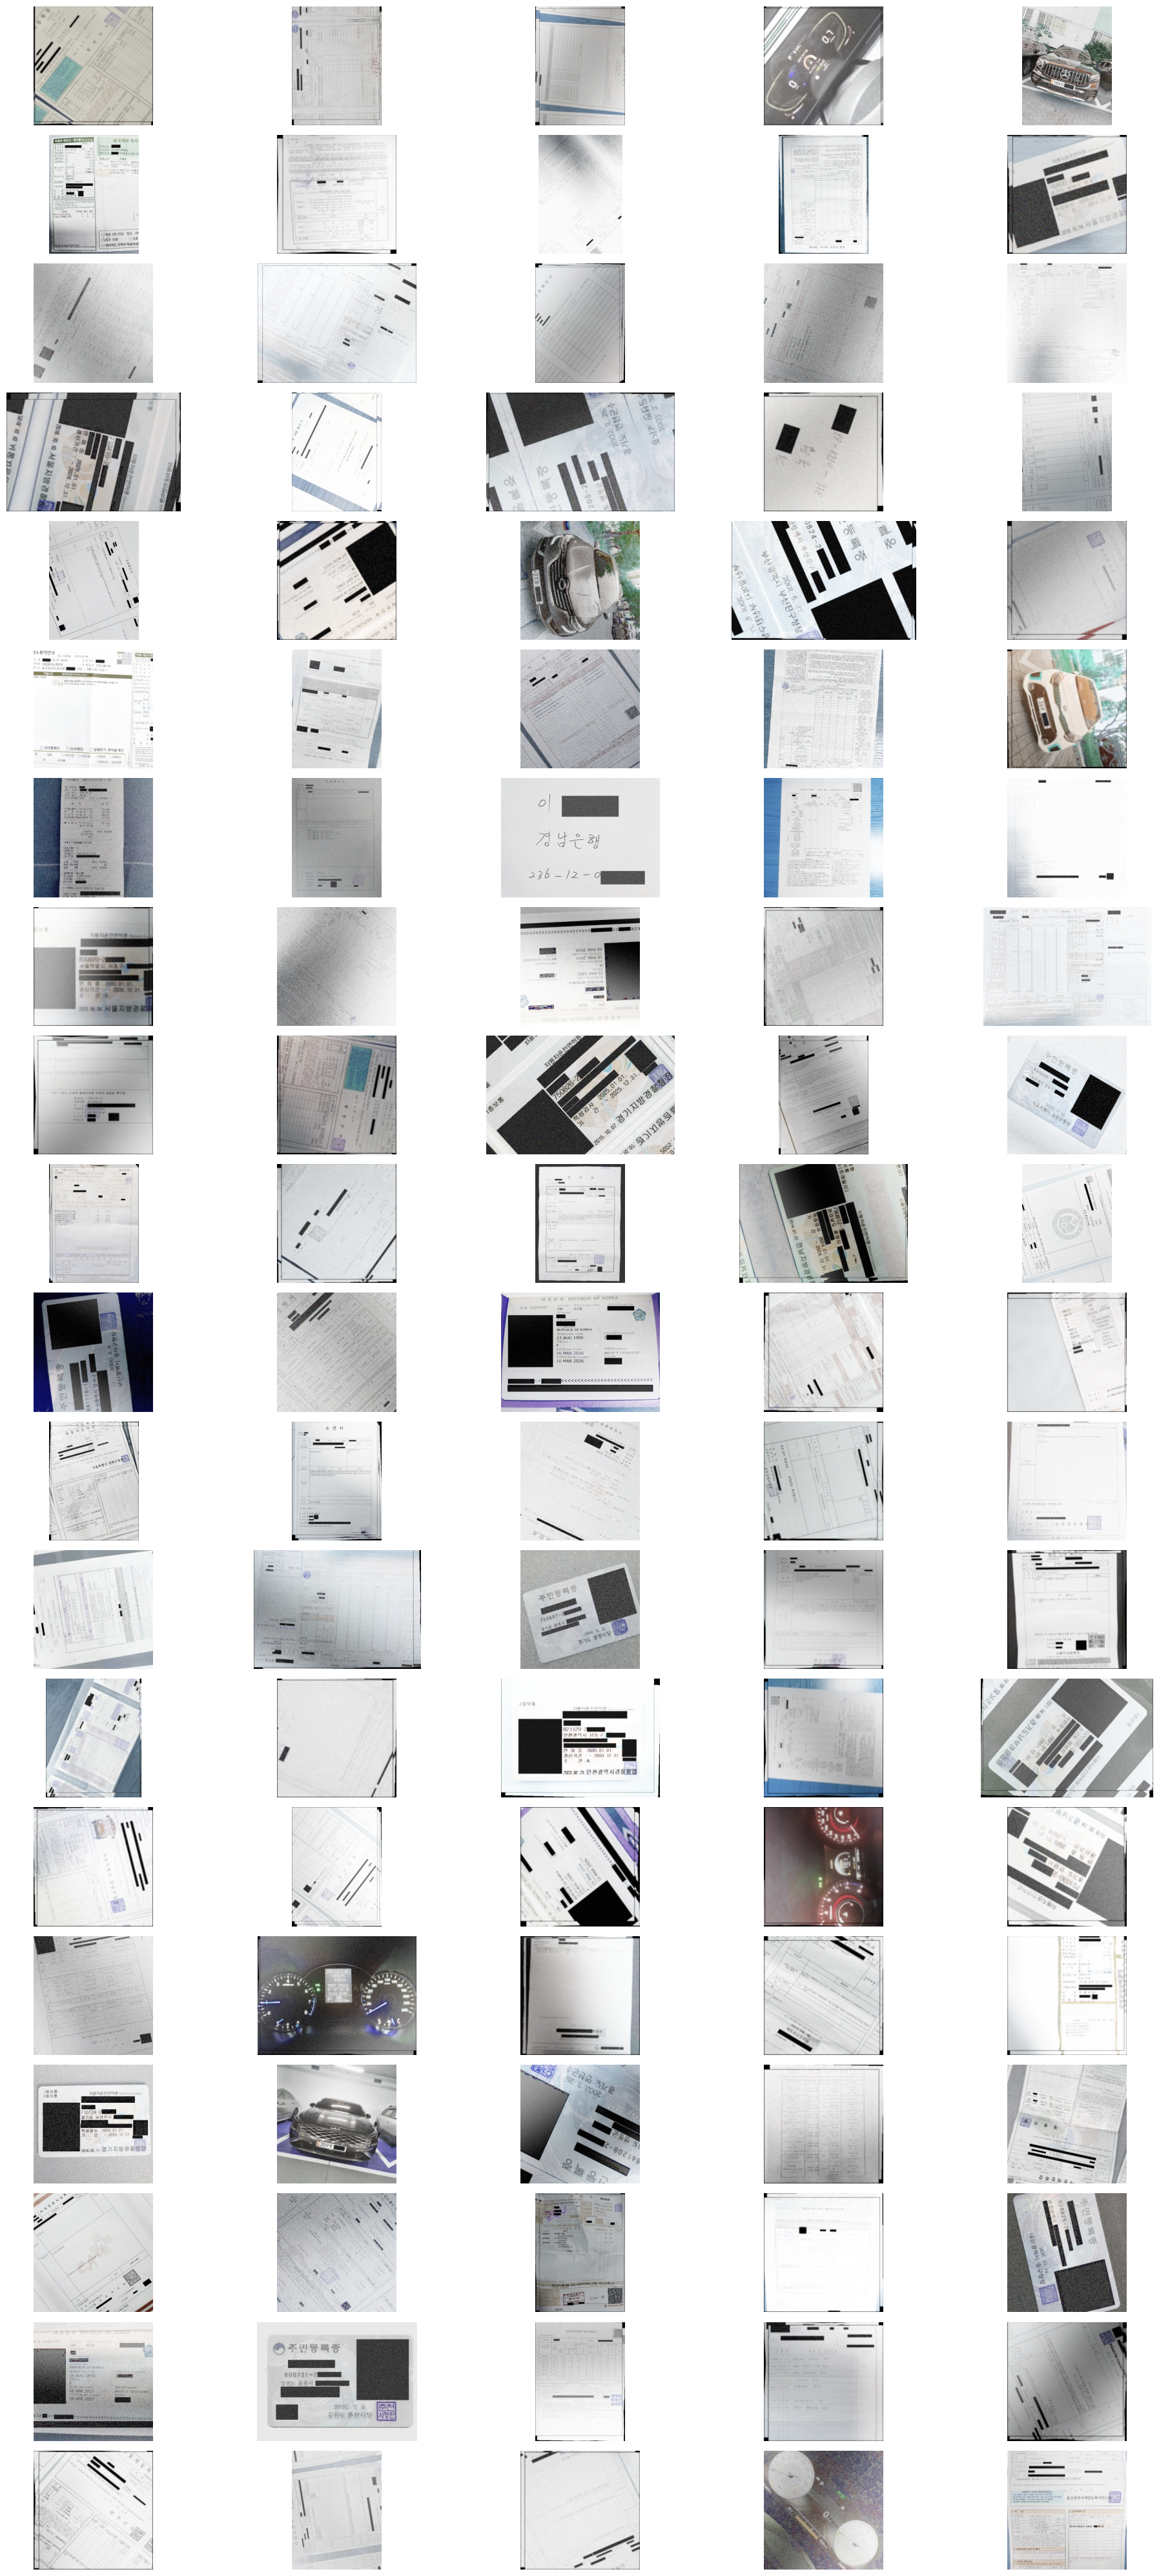

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 데이터 경로 설정
output_dir = "data/augmented_v3_x50_cleaning"

# 증강된 이미지 파일 목록 불러오기
image_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith((".jpg", ".jpeg", ".png"))]

# 랜덤으로 100개 이미지 선택
selected_images = random.sample(image_files, 100)

# 20x5 그리드로 시각화
fig, axes = plt.subplots(20, 5, figsize=(20, 40))

for ax, img_path in zip(axes.flatten(), selected_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()
